In [103]:
import sys
import os

# Get the absolute path to the repo root (parent of both src and notebook folders)
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add the repo root to the Python path
sys.path.append(repo_root)

# Now you can import from src
from src.master.data import load_and_crop_data
from src.master.visualize import show_masks_sam, visualize_masks
from src.master.evaluate import evaluate_binary_masks

In [114]:
from transformers import pipeline

checkpoint = "google/owlv2-base-patch16-ensemble"
detector = pipeline(model=checkpoint, task="zero-shot-object-detection")

Device set to use cuda:0


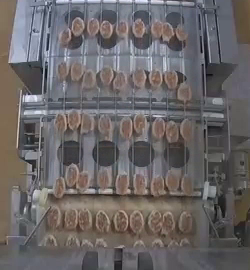

In [130]:
import numpy as np
from PIL import Image

meatball_img_path = "C:/Users/gtoft/OneDrive/DTU/4_Semester_AS/Master_Thesis/data/processed/meatballs/images/train/frame_001224.PNG"
meatball_label_path = "C:/Users/gtoft/OneDrive/DTU/4_Semester_AS/Master_Thesis/data/processed/meatballs/labels/train/frame_001224.txt"

crop_coords = (200, 30, 450, 300)  # As (x_start, y_start, x_end, y_end)

image = Image.open(meatball_img_path).convert("RGB")
image = image.crop(crop_coords)

image

In [131]:
crop_coords = (30, 300, 200, 450)
img, labels = load_and_crop_data(meatball_img_path, meatball_label_path, crop_coords)

In [132]:
predictions = detector(
    image,
    candidate_labels=["meatball"],
)

In [133]:
predictions

[{'score': 0.12157714366912842,
  'label': 'meatball',
  'box': {'xmin': 44, 'ymin': 16, 'xmax': 199, 'ymax': 245}},
 {'score': 0.101393923163414,
  'label': 'meatball',
  'box': {'xmin': 44, 'ymin': 207, 'xmax': 190, 'ymax': 234}}]

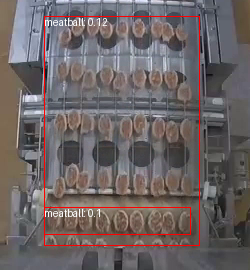

In [134]:
from PIL import ImageDraw

draw = ImageDraw.Draw(image)

for prediction in predictions:
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]

    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{label}: {round(score,2)}", fill="white")

image

In [135]:
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from sam2.build_sam import build_sam2
from sam2.utils.misc import variant_to_config_mapping

model = build_sam2(
    variant_to_config_mapping["small"],
    "../models/sam2_hiera_small.pt",
)

mask_generator = SAM2AutomaticMaskGenerator(
    model,
    points_per_side=32,           # Increased from default 32
    pred_iou_thresh=0.7,          # Lowered from default 0.8
    stability_score_thresh=0.85,  # Lowered from default 0.95
    box_nms_thresh=0.6,           # Lowered from default 0.7
    )

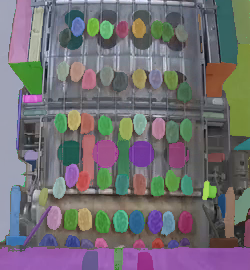

In [136]:
masks = mask_generator.generate(img)

meatball_output_mask = show_masks_sam(image = img, masks = masks, scores=None, only_best=False, autogenerated_mask=True)

meatball_output_mask

In [137]:
masks_full_seg = []

for  mask in masks:
    bi_mask = mask["segmentation"]
    masks_full_seg.append(bi_mask)

In [138]:
import numpy as np

def suppress_masks_outside_box(masks, bbox):
    """
    Suppresses all masks that are not strictly within the given bounding box.
    
    Parameters:
    -----------
    masks : list of numpy.ndarray
        List of binary masks, where each mask is a 2D numpy array with 1s for the mask region
        and 0s elsewhere.
    bbox : tuple
        Bounding box in format (x_min, y_min, x_max, y_max) where coordinates are inclusive.
        
    Returns:
    --------
    list of numpy.ndarray
        List containing only the masks that are strictly within the bounding box.
    """
    x_min, y_min, x_max, y_max = bbox
    filtered_masks = []
    
    for mask in masks:
        # Find coordinates of all non-zero elements (the mask area)
        y_coords, x_coords = np.where(mask > 0)
        
        # Check if all mask pixels are within the bounding box
        if (len(x_coords) > 0 and len(y_coords) > 0 and
            np.min(x_coords) >= x_min and np.max(x_coords) <= x_max and
            np.min(y_coords) >= y_min and np.max(y_coords) <= y_max):
            filtered_masks.append(mask)
    
    return filtered_masks

In [139]:
bbox = (44, 16, 199, 245)
sup_masks = suppress_masks_outside_box(masks_full_seg, bbox)

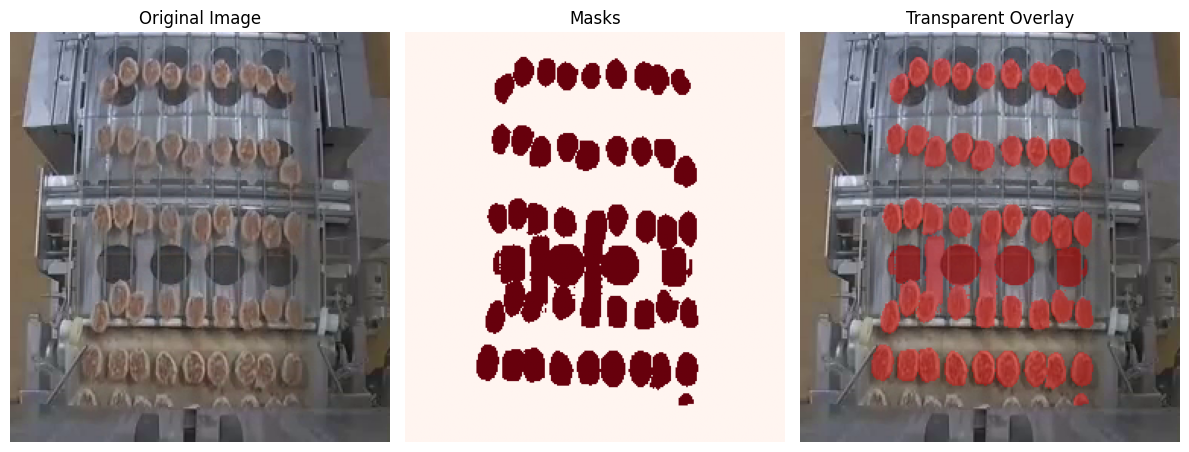

In [140]:
visualize_masks(img, sup_masks)

In [141]:
results = evaluate_binary_masks(labels, sup_masks)

print(f"Mask Detection Rate (Recall): {results['mask_recall']:.4f}")
print(f"Mask Precision: {results['mask_precision']:.4f}")
print(f"Detected {results['detected_masks']} out of {results['total_gt_masks']} GT masks")
print(f"Average IoU of detected masks: {results['avg_iou_detected']:.4f}")

Mask Detection Rate (Recall): 0.8679
Mask Precision: 0.8364
Detected 46 out of 53 GT masks
Average IoU of detected masks: 0.8620


In [92]:
print(len(sup_masks))

31
